<p align ="center">
<img width=600 src = "https://res.cloudinary.com/dltwftrgc/image/upload/v1712504276/Projects/EmbedAnything_500_x_200_px_a4l8xu.png">
</p>


<p align="center">
    <b>Framework for building local and multimodal embeddings built in Rust 🦀 for speed and robustness</b>
</p>


In [ ]:
!pip install embed-anything

import os
if not os.path.exists("EmbedAnything"):
  !git clone https://github.com/StarlightSearch/EmbedAnything.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.2 MB/s eta 0:00:00
Cloning into 'EmbedAnything'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 575 (delta 83), reused 102 (delta 46), pack-reused 406
Receiving objects: 100% (575/575), 6.33 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [ ]:
import embed_anything
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import math

In [ ]:
# Installing the required packages to make the connection with the Pinecone

!pip install pinecone-client[grpc]
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
# Initializing the client connection to pinecone
pc = Pinecone(api_key='0ed69089-c5c6-44e9-86c1-e7753fa0ed13')  #Insert your Pinecone API here


## Displaying various images present in the Clip Folder

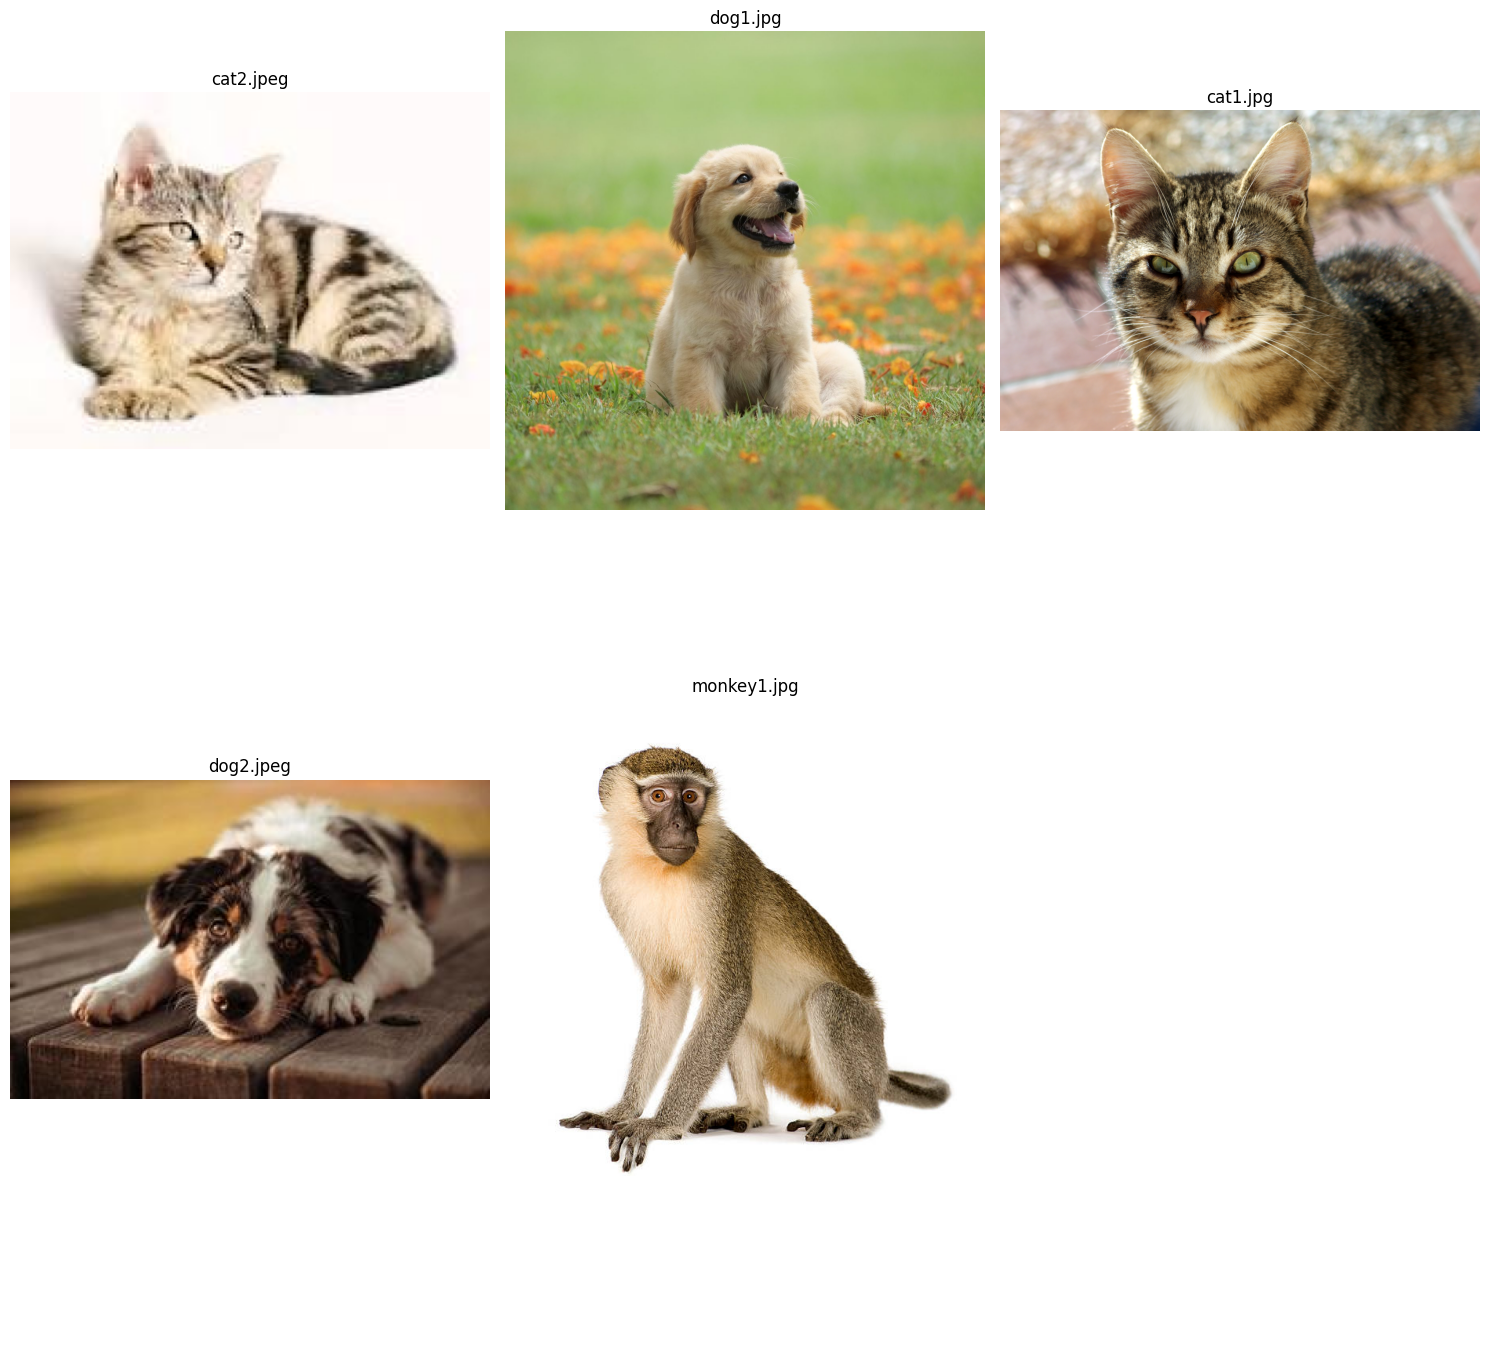

In [ ]:
# Directory containing images
image_dir = "/content/EmbedAnything/test_files/clip"

# Get a list of image file names
image_files = os.listdir(image_dir)

# Number of images
num_images = len(image_files)

num_columns = 3
num_rows = math.ceil(num_images / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through all files and display images
for ax, image_name in zip(axes, image_files):
    photo_loc = os.path.join(image_dir, image_name)
    img = Image.open(photo_loc)

    # Display the image
    ax.imshow(img)
    ax.set_title(image_name)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# To check the already existing indexes in Database
pc.list_indexes().names()

[]

## Creating Index in the Pinecone

In [ ]:
index_name = "first-index-embed-anything"

# Code to create serverless index,pinecone also have an option to create pod based index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,  # Dimension,based on the embedding model you used to embed files
        metric="cosine", # Following are the available metrics {"cosine", "dotproduct", "euclidean"}
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
index = pc.Index(index_name)


## Creating Embeddings 

In [ ]:
def create_embeddings(img_folder_loc,embeder_model):
  data = embed_anything.embed_directory(img_folder_loc, embeder= embeder_model) # It is list of EmbedData Objects
  embeddings = [data.embedding for data in data] # Extracting embeddings from EmbedData objects
  file_names =os.listdir(img_folder_loc)

  # Format of vectors needed, to insert embeddings using the upsert command
  # vectors=[
  #     {"id": "vec1", "values": [1.0, 1.5]},
  #     {"id": "vec2", "values": [2.0, 1.0]}]

  pinecone_vectors = [{"id":str(id),"values": embedding} for id,embedding in zip(file_names,embeddings)]
  return pinecone_vectors


In [ ]:
pinecone_embeddings = create_embeddings(img_folder_loc="/content/EmbedAnything/test_files/clip",embeder_model="Clip")

## Upserting the embeddings

In [ ]:
def insert_elements(pinecone_embeddings,index_object):
    return index.upsert(vectors = pinecone_embeddings,namespace="ns1")
# Through namespaces we can do  partitioning of the records within an index. It is not mandatory to store  embeddings in namespaces,it depends on the way user wants to use the embeddings.



In [ ]:
insert_elements(pinecone_embeddings,index_object=index)

upserted_count: 5

In [ ]:
# describe_index_stats operation to check if the current vector count matches the number of vectors you upserted
print(index.describe_index_stats())


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'ns1': {'vector_count': 5}},
 'total_vector_count': 5}


In [ ]:
query_results1 = index.query(
    namespace="ns1",
    vector=embed_anything.embed_file(os.path.join("/content/EmbedAnything/test_files/clip",'dog1.jpg'), embeder= "Clip")[0].embedding,
    top_k=5
)

print(query_results1)

{'matches': [{'id': 'dog1.jpg',
              'metadata': None,
              'score': 1.0,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'dog2.jpeg',
              'metadata': None,
              'score': 0.7923146,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'cat1.jpg',
              'metadata': None,
              'score': 0.7749568,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'cat2.jpeg',
              'metadata': None,
              'score': 0.7710281,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'monkey1.jpg',
              'metadata': None,
              'score': 0.6461063,
              'sparse_values': {'indices': [], 'values': []},
              'values': []}],
 'namespace': 'ns1',
 'usage': {'read_units': 5}}


In [ ]:
query_results2 = index.query(
    namespace="ns1",
    vector=embed_anything.embed_file(os.path.join("/content/EmbedAnything/test_files/clip",'cat1.jpg'), embeder= "Clip")[0].embedding,
    top_k=5
)

print(query_results2)

{'matches': [{'id': 'cat1.jpg',
              'metadata': None,
              'score': 1.0,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'cat2.jpeg',
              'metadata': None,
              'score': 0.88211524,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'dog2.jpeg',
              'metadata': None,
              'score': 0.7861585,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'dog1.jpg',
              'metadata': None,
              'score': 0.7749569,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 'monkey1.jpg',
              'metadata': None,
              'score': 0.70853865,
              'sparse_values': {'indices': [], 'values': []},
              'values': []}],
 'namespace': 'ns1',
 'usage': {'read_units': 5}}


In [ ]:
pc.delete_index(index_name)
